# 9-13. 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!
## 2019 2nd ML month with KaKR : House Price Prediction

### [루브릭]
* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
* 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

### [학습과정]
1. 데이터 살펴보기
2. 데이터 시각화
3. 데이터 전처리
4. 모델링
5. 결과 분석


### [결과 및 회고]

## 1. Data 살펴보기

#### 1.1 feature 종류
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

#### 1.2 데이터 불러오기

In [43]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import scipy.stats as sp

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
data_dir = os.getenv('HOME')+'/project/AIFFEL/E09_Kaggle_2019kaKrHousing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/ssac18/project/AIFFEL/E09_Kaggle_2019kaKrHousing/data/train.csv
/home/ssac18/project/AIFFEL/E09_Kaggle_2019kaKrHousing/data/test.csv


In [33]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [34]:
data        # train data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [35]:
sub          # submission data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


train data를 보면
* id 는 index 컬럼과 동일하기 때문에 학습시 필요 없는 컬럼이므로 제거해주어야 합니다.
* date 컬럼은  yyyy-mm-dd + T000000의 형태로, 우리는 앞의 8자리만 필요합니다.
* bathroom 컬럼이 정수가 아닌 유리수의 형태로 나타나있는데, 이들이 각각 무엇을 뜻하는지 확인 필요
* 재건축 유무 추가? 주거 공간이나 부지의 변화 있으면 확인해보기

In [36]:
# target data 제거

y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [37]:
# train data와 sub(test) data 길이 합치기

train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


## 2. Data 시각화

In [41]:
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

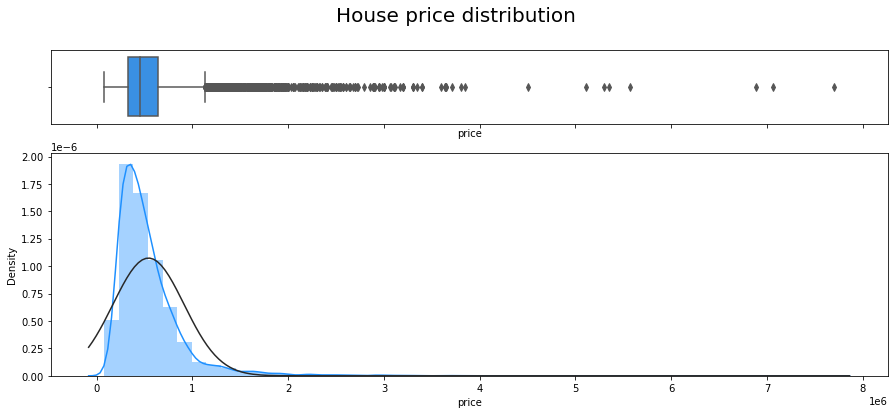

In [44]:
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(15, 6), sharex=True, gridspec_kw = {"height_ratios": (.25, .75)})
f.suptitle("House price distribution", fontsize=20)

sns.boxplot(y, ax=ax_box, color = 'dodgerblue')
p = sns.distplot(y, ax=ax_hist, fit = sp.norm, color = 'dodgerblue')

In [46]:
# 왜도와 첨도 확인하기

print("Skewness(왜도): ", y.skew())
print("Kurtosis(첨도): ", y.kurt())

Skewness(왜도):  4.290252396939529
Kurtosis(첨도):  40.15491919350329


* 왜도값이 클수록 오른쪽으로 꼬리가 깁니다. 현재 왜도 값은 약 4.29이고, 데이터의 분포가 왼쪽으로 치우쳐있고 오른쪽으로 꼬리가 긴편이라는 걸 알 수 있습니다.
* 첨도 값은 그 값이 3에 가까울수록(K=3) 정규분포에 가깝습니다. 현재 K = 40.15으로 매우 뾰족한 형태를 지님을 알 수 있습니다.


따라서, target을 Normalize함으로써 정규분포를 따르도록 합니다.

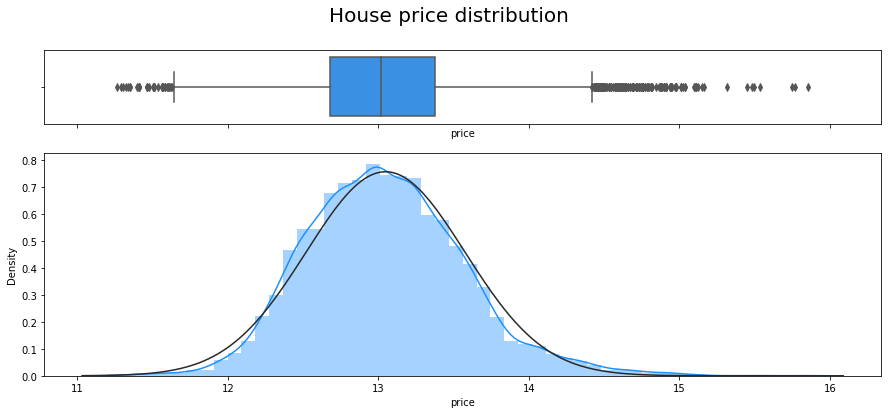

In [47]:
y = np.log1p(y)

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(15, 6), sharex=True, gridspec_kw = {"height_ratios": (.25, .75)})
f.suptitle("House price distribution", fontsize=20)

sns.boxplot(y, ax=ax_box, color = 'dodgerblue')
p = sns.distplot(y, ax=ax_hist, fit = sp.norm, color = 'dodgerblue')

정규분포 형태로 아름답게 변했습니다.   

이제, target인 price와 다른 feature들간의 상관관계를 살펴보겠습니다.

## 3. Data 전처리
#### 3.1 이상치, 결측치 확인

<AxesSubplot:xlabel='sqft_lot15'>

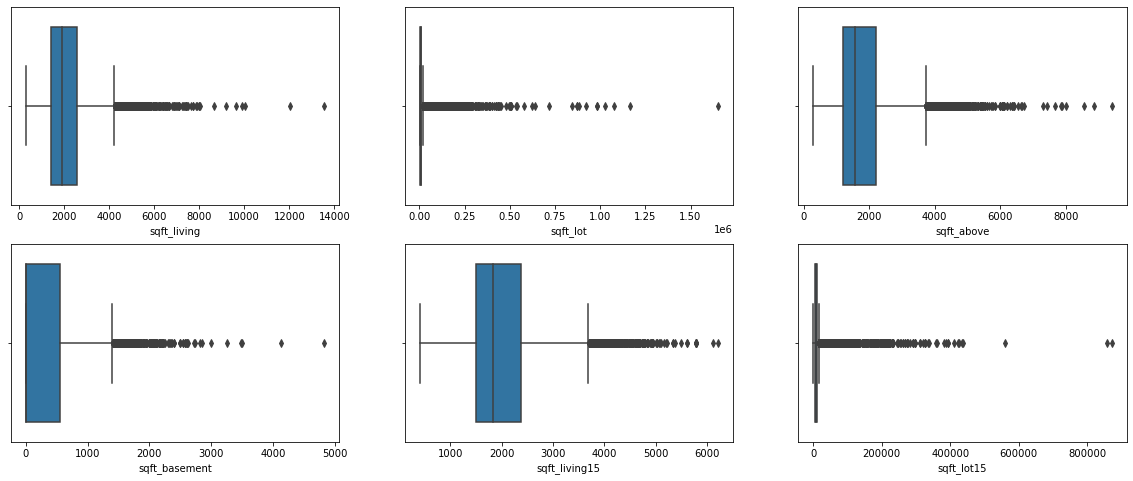

In [38]:
# 이상치 확인 

plt.figure(figsize=(20,8))
plt.subplot(231)
sns.boxplot(x=data.sqft_living)

plt.subplot(232)
sns.boxplot(x=data.sqft_lot)

plt.subplot(233)
sns.boxplot(x=data.sqft_above)

plt.subplot(234)
sns.boxplot(x=data.sqft_basement)

plt.subplot(235)
sns.boxplot(x=data.sqft_living15)

plt.subplot(236)
sns.boxplot(x=data.sqft_lot15)

<AxesSubplot:xlabel='grade'>

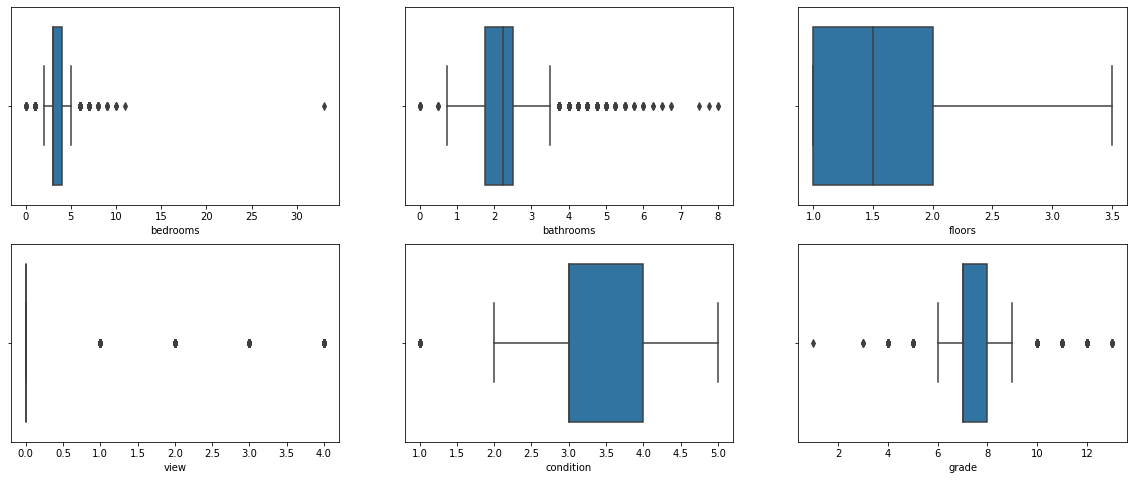

In [39]:
plt.figure(figsize=(20,8))

plt.subplot(231)
sns.boxplot(x=data.bedrooms)

plt.subplot(232)
sns.boxplot(x=data.bathrooms)

plt.subplot(233)
sns.boxplot(x=data.floors)

plt.subplot(234)
sns.boxplot(x=data.view)

plt.subplot(235)
sns.boxplot(x=data.condition)

plt.subplot(236)
sns.boxplot(x=data.grade)

In [40]:
a = data[data['id']==8990]
a

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8990,8990,20140912T000000,3,1.0,1020,6173,1.0,0,0,3,6,780,240,1948,0,98168,47.5042,-122.329,1330,5909


<AxesSubplot:>

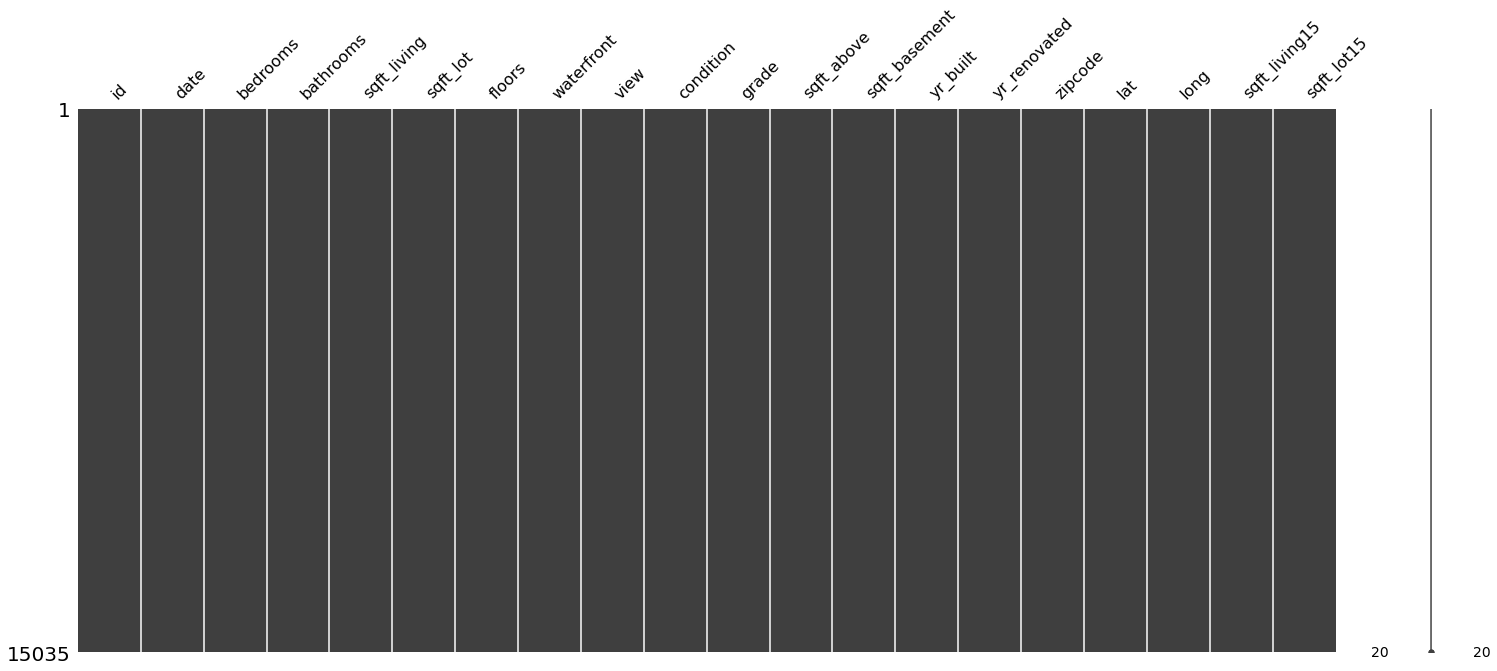

In [8]:
# 결측치 확인
msno.matrix(data)

결측치 없음

In [12]:
# id feature 제거
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### [결과 및 회고]

이번 프로젝트를 하면서 이루고 싶었던 목표는 3가지 입니다.
1. 최적의 모델링을 통한 RMSE 값 최소화
2. 데이터 분석의 전체적인 과정 배우기
3. 데이터 처리에서 자주 사용되는 문법 익히기